# Modern Baybayin Recognition

In [1]:
# import sys
# !{sys.executable} -m pip install scikit-image
# !{sys.executable} -m pip install ann_visualizer
# !{sys.executable} -m pip install visualkeras
import time

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
                               # io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import seaborn as sns
import tensorflow as tf  # deep learning library. Tensors are just multi-dimensional arrays
from ann_visualizer.visualize import ann_viz
import visualkeras

In [3]:
MODEL_NAME = f'3-conv-64-nodes-1-dense-512-dropout-0-{int(time.time())}'

tensorboard = TensorBoard(log_dir=f'logs/{MODEL_NAME}')

In [2]:
xfile = 'baybayin_characters_x_test.npy'
yfile = 'baybayin_characters_y_test.npy'

# Load the numpy binary files
X = np.load(xfile)
y = np.load(yfile)
X.shape, y.shape

((167076, 80, 80), (167076,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# X_train.shape

In [4]:
x_train_normalized = tf.keras.utils.normalize(X_train, axis=1)  # scales data between 0 and 1
x_test_normalized = tf.keras.utils.normalize(X_test, axis=1)  # scales data between 0 and 1

# Scale the data so that the values are from 0 - 1
# x_train = X_train / 255
# x_test = X_test / 255

In [5]:
x_train_normalized[0][10]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33333333, 0.2236068 , 0.21821789, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.20397004, 0.18569534,
       0.14586499, 0.14744196, 0.17149859, 0.31622777, 0.33333333,
       0.37796447, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.29807583, 0.22940645, 0.22941573, 0.25817242, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

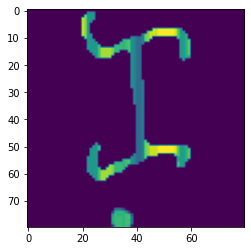

In [9]:
plt.imshow(x_train_normalized[0])

In [10]:
print(y_train[0])

KO/KU


In [11]:
# Flattening the train and test data
# x_train_flattened = x_train.reshape(len(x_train), 80*80)
# x_test_flattened = x_test.reshape(len(x_test), 80*80)

In [6]:
IMG_SIZE=80
# -1 is a shorthand, which returns the length of the dataset
x_trainr = np.array(x_train_normalized).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_testr = np.array(x_test_normalized).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print("Training Samples dimension", x_trainr.shape)
print("Testing Samples dimension", x_testr.shape)
# Training Samples dimension (133660, 80, 80, 1)
# Testing Samples dimension (33416, 80, 80, 1)

Training Samples dimension (133660, 80, 80, 1)
Testing Samples dimension (33416, 80, 80, 1)


In [7]:
le = LabelEncoder()
y_train_final = le.fit_transform(y_train)
y_test_final = le.fit_transform(y_test)
# one hot encode target values

In [8]:
classes = list(le.classes_)

In [14]:
classes[18]

'K'

In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
def construct_model(learningRate):
    smodel = Sequential()
    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=x_trainr.shape[1:], activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
#     smodel.add(Dropout(0.8))
    
    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
#     smodel.add(Dropout(0.8))

    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
#     smodel.add(Dropout(0.8))

    smodel.add(Flatten())
    smodel.add(Dense(512, activation='relu'))
#     smodel.add(Dense(256, activation='relu'))
    smodel.add(Dense(63, activation='softmax'))
    optimizer = Adam(learning_rate=learningRate)
    smodel.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_m,precision_m, recall_m])
#     smodel.summary()
    return smodel

In [18]:
model=construct_model(0.0001)

In [19]:
model.fit(x_trainr, y_train_final, epochs=5, callbacks=[tensorboard])  # train the model

Epoch 1/5
4177/4177 [==============================] - 950s 227ms/step - loss: 0.4230 - accuracy: 0.8645 - f1_m: 3.3926 - precision_m: 167531744.0000 - recall_m: 2.6872
Epoch 2/5
4177/4177 [==============================] - 997s 239ms/step - loss: 0.0651 - accuracy: 0.9798 - f1_m: 1.2147 - precision_m: 1.2083 - recall_m: 1.2215
Epoch 3/5
4177/4177 [==============================] - 990s 237ms/step - loss: 0.0317 - accuracy: 0.9903 - f1_m: 1.0997 - precision_m: 1.0923 - recall_m: 1.1077
Epoch 4/5
4177/4177 [==============================] - 926s 222ms/step - loss: 0.0182 - accuracy: 0.9942 - f1_m: 1.0536 - precision_m: 1.0458 - recall_m: 1.0618
Epoch 5/5
4177/4177 [==============================] - 923s 221ms/step - loss: 0.0122 - accuracy: 0.9963 - f1_m: 1.0332 - precision_m: 1.0253 - recall_m: 1.0414


In [20]:
val_loss, val_acc, f1_score, precision, recall = model.evaluate(x_testr, y_test_final)  # evaluate the out of sample data with model
print("Loss: ", val_loss)  # model's loss (error)
print("Accuracy: ", val_acc)  # model's accuracy
print("F1 measure: ", f1_score)  # model's f1_score
print("Precision: ", precision)  # model's precision
print("Recall: ", recall)  # model's recall

1045/1045 [==============================] - 60s 57ms/step - loss: 0.0289 - accuracy: 0.9913 - f1_m: 1.0431 - precision_m: 1.0353 - recall_m: 1.0513
Loss:  0.02889343909919262
Accuracy:  0.9912616610527039
F1 measure:  1.0430597066879272
Precision:  1.035258173942566
Recall:  1.0512607097625732


In [21]:
model.save(MODEL_NAME)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 3-conv-64-nodes-1-dense-512-dropout-0-1670254200/assets


In [22]:
predictions = model.predict(x_testr)

NO/NU


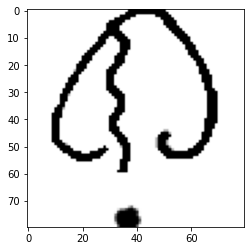

In [23]:
index = 6

plt.imshow(X_test[index], cmap='Greys')
print(classes[np.argmax(predictions[index])])

In [24]:
y_predicted_labels = [np.argmax(i) for i in predictions]
y_predicted_labels[:5]

[57, 12, 3, 51, 46]

In [25]:
cm = tf.math.confusion_matrix(labels=y_test_final, predictions=y_predicted_labels)
cm
# y_test_final

<tf.Tensor: shape=(63, 63), dtype=int32, numpy=
array([[533,   0,   0, ...,   0,   0,   0],
       [  0, 509,   1, ...,   0,   0,   0],
       [  0,   0, 493, ...,   0,   0,   0],
       ...,
       [  4,   0,   0, ..., 501,   2,   0],
       [  1,   0,   0, ...,   1, 522,   0],
       [  0,   0,   0, ...,   0,   0, 542]], dtype=int32)>

Text(204.0, 0.5, 'Truth')

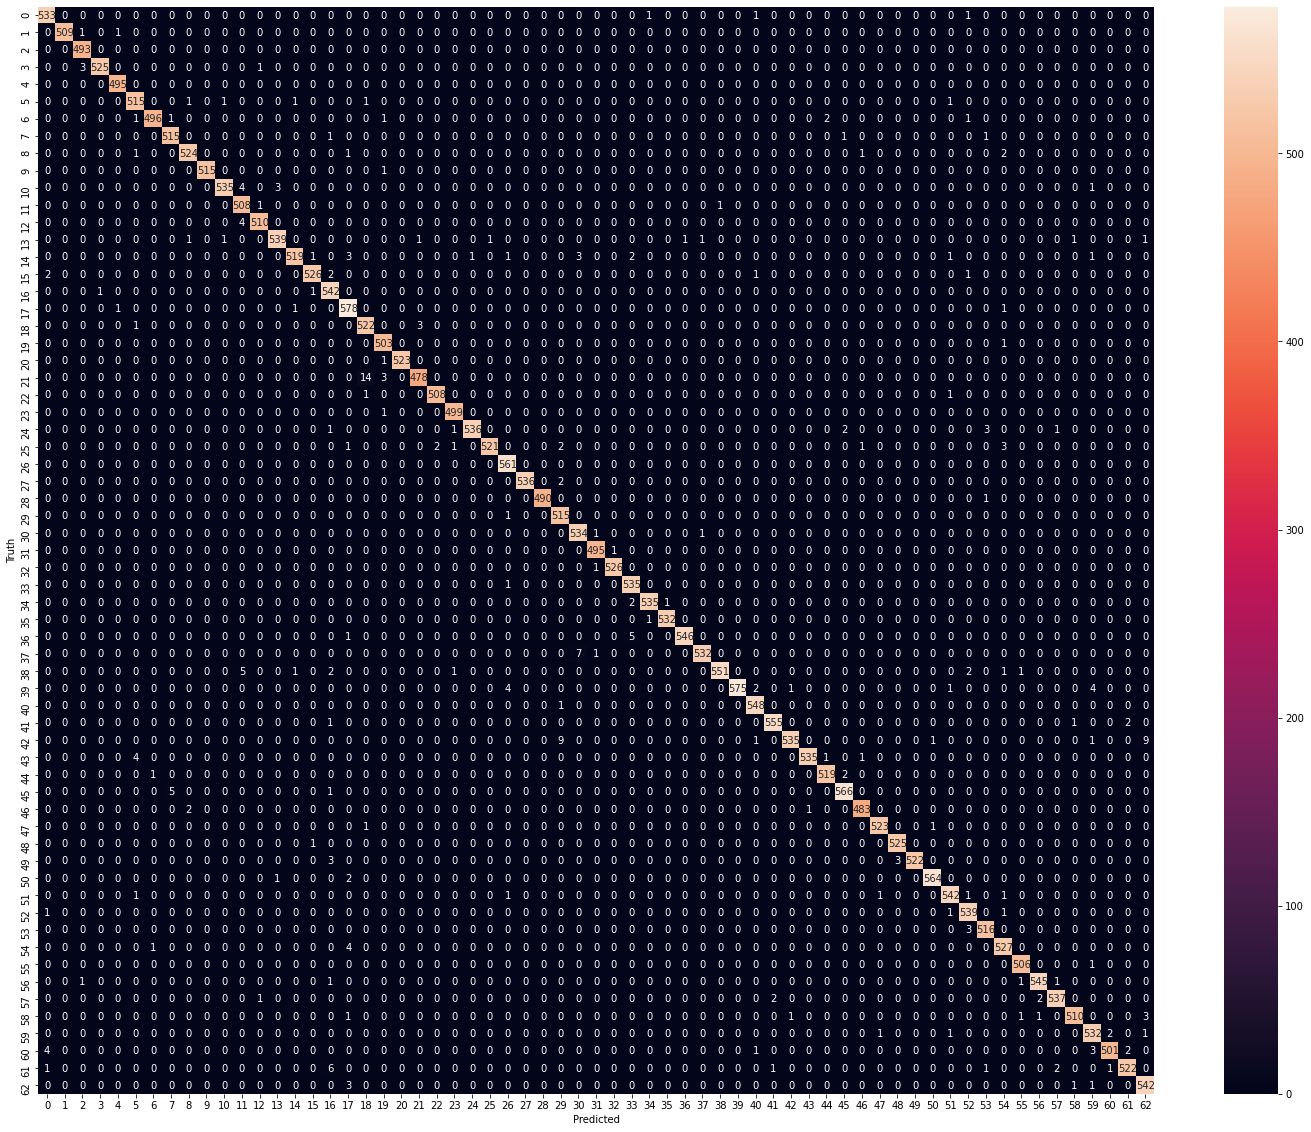

In [26]:
import seaborn as sn
plt.figure(figsize = (25,20))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [27]:
classes[41], classes[61]

('PE/PI', 'YE/YI')